# Frac Gradient Analysis

The purpose of this project is to develop a method for automatically computing initial shut-in pressure (ISIP) and open wellhead pressure based upon a given frac profile. Currently the ISIP and open wellhead pressure are eyeballed by the appropriate engineer and recorded for future use. This notebook will show a method for automating these computations.

## Data Import And Cleaning

To begin we will import a standard frac data set and clean it up so only the relevant data remains. We will also split out each stage into it's own dataframe housed within a dictionary.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#Import data and convert to datetime
frac_data = pd.read_csv('/Users/anthonyfonte/Frac_gradient_Project/data/Frac stage data.csv')
cols = ['Time','Net_Pressure_Time','Stage_Counter','Blender_Slurry_Rate','Treating_Pressure','API','WELL_NAME','STAGE_NUMBER']
frac_data = frac_data[cols].copy()
frac_data['Flag'] = 0
frac_data['Time'] = pd.to_datetime(frac_data['Time'])
frac_data.set_index('Time',inplace=True)

#Create a dictionary containing each stage as a dataframe
stage_data = {}
num_stages = frac_data['STAGE_NUMBER'].unique()

for i in range(num_stages.min(),num_stages.max()+1):
    stage_data[i] = frac_data[frac_data['STAGE_NUMBER']==i].copy()
    stage_data[i].sort_index(inplace=True)

Now that the data is read in, we will split out each stage into it's own dataframe housed within a dictionary and look at each stage graphically to make sure the data looks appropriate.

In [2]:
# Plot bottom hold pressure and slurry rate for one stage
def full_frac_plot(i):
    fig, ax1 = plt.subplots()
    ln1 = ax1.plot(stage_data[i].index,stage_data[i]['Treating_Pressure'],label='Treating Pressure')
    ax1.set_ylabel('Pressure (psi)')
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax1.set_xlabel('Time (HH:MM)')
    ax1.tick_params(axis='x', labelrotation = 45)

    ax2 = ax1.twinx()
    ln2 = ax2.plot(stage_data[i].index,stage_data[i]['Blender_Slurry_Rate'],color='red',label='Slurry Rate')
    ax2.set_ylim(bottom=0)
    ax2.set_ylabel('Slurry Rate (bpm)')
    
    lns = ln1 + ln2
    labs = [l.get_label() for l in lns]
    
    plt.title('Stage ' + str(i))
    plt.tight_layout()
    plt.legend(lns, labs, bbox_to_anchor=(1,1.05))
    fig.canvas.draw()
    
    return fig, ax1, ax2

#Plot data between two flags
def flag_frac_plot(i,idx_a,idx_b):
    fig, ax1 = plt.subplots()
    flag_data = stage_data[i][idx_a:idx_b]
    ln1 = ax1.plot(flag_data.index,flag_data['Treating_Pressure'],label='Treating Pressure')
    ax1.set_ylabel('Pressure (psi)')
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax1.set_xlabel('Time (HH:MM)')
    ax1.tick_params(axis='x', labelrotation = 45)

    ax2 = ax1.twinx()
    ln2 = ax2.plot(flag_data.index,flag_data['Blender_Slurry_Rate'],color='red',label='Slurry Rate')
    ax2.set_ylim(bottom=0)
    ax2.set_ylabel('Slurry Rate (bpm)')
    
    lns = ln1 + ln2
    labs = [l.get_label() for l in lns]
    
    plt.title('Stage ' + str(i))
    plt.tight_layout()
    plt.legend(lns, labs, bbox_to_anchor=(1,1.05))
    fig.canvas.draw()
    
    return fig, ax1, ax2

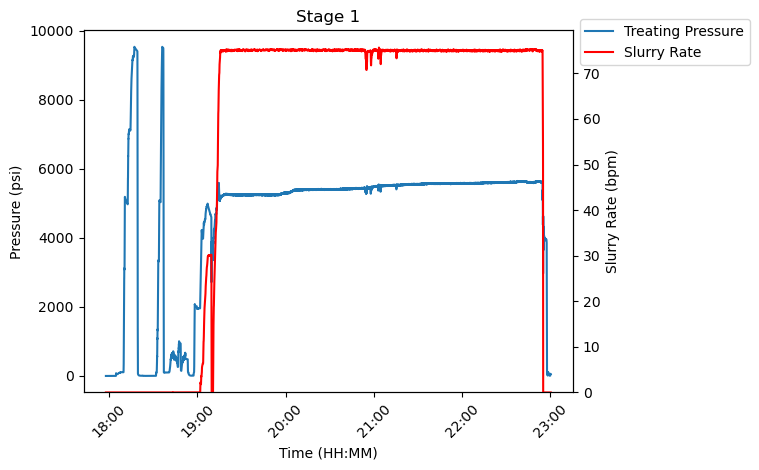

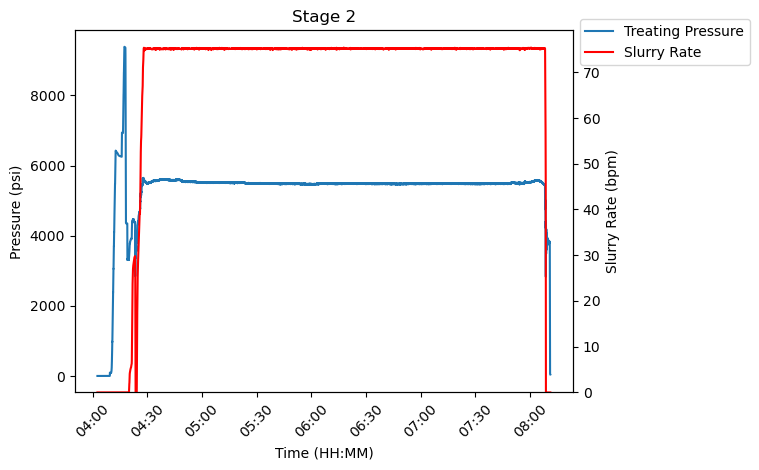

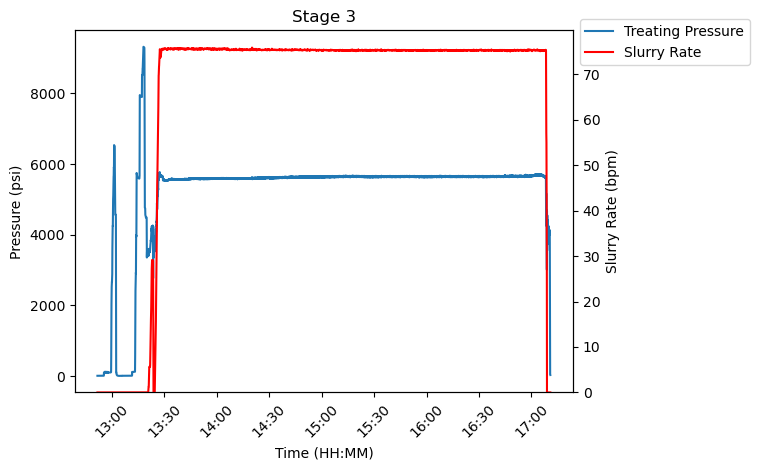

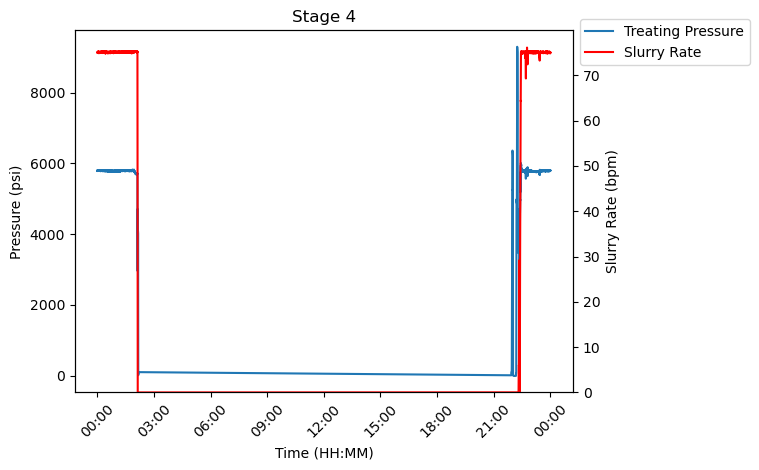

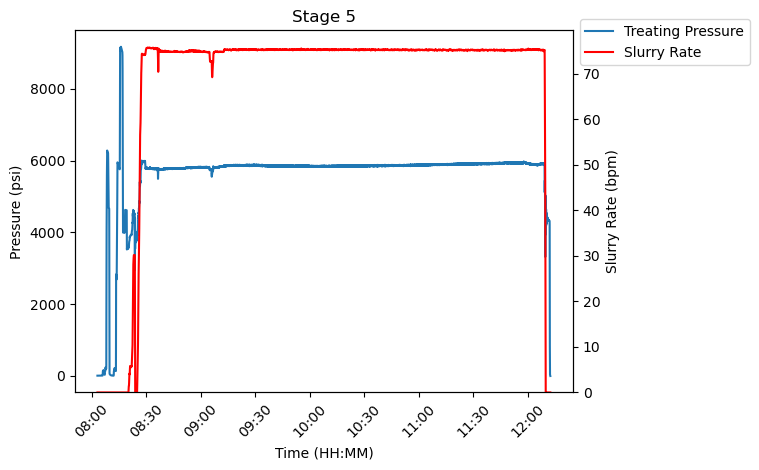

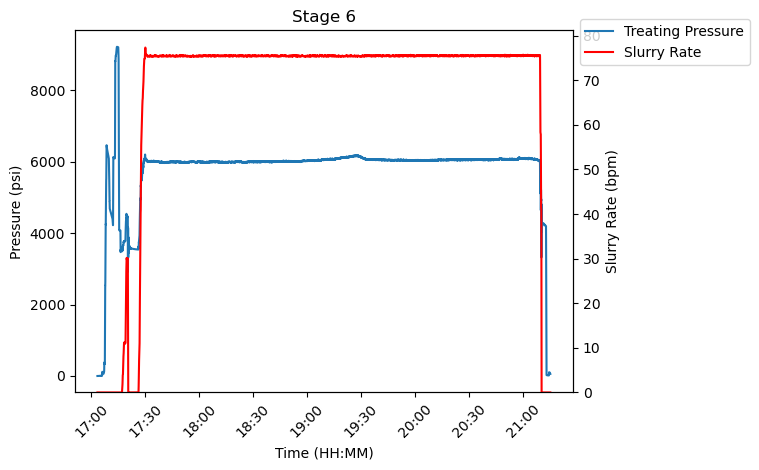

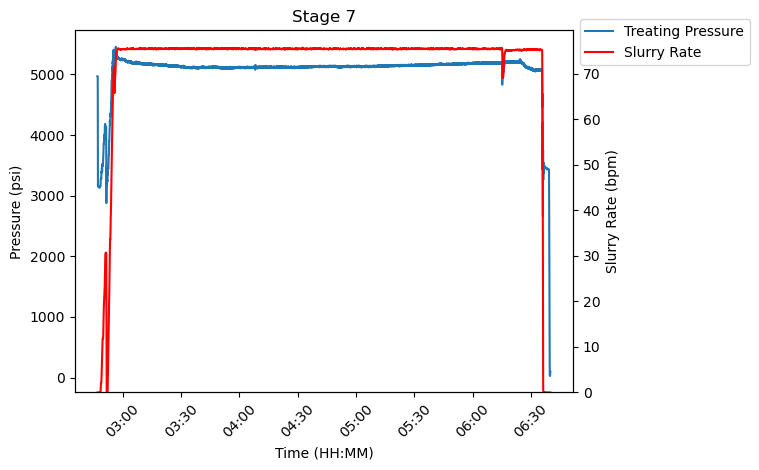

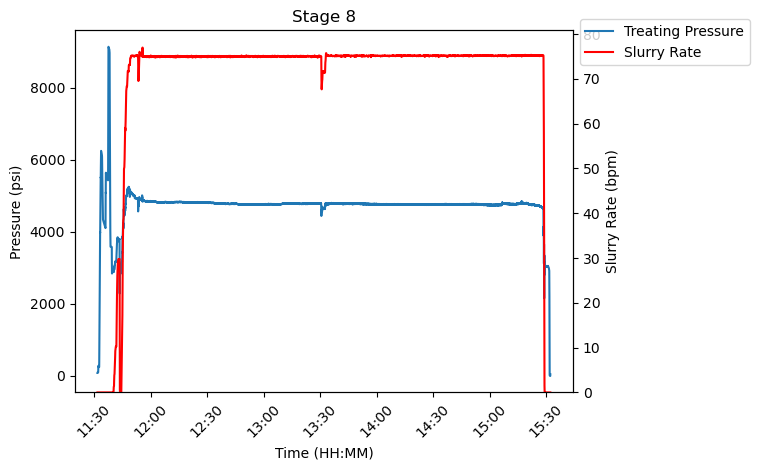

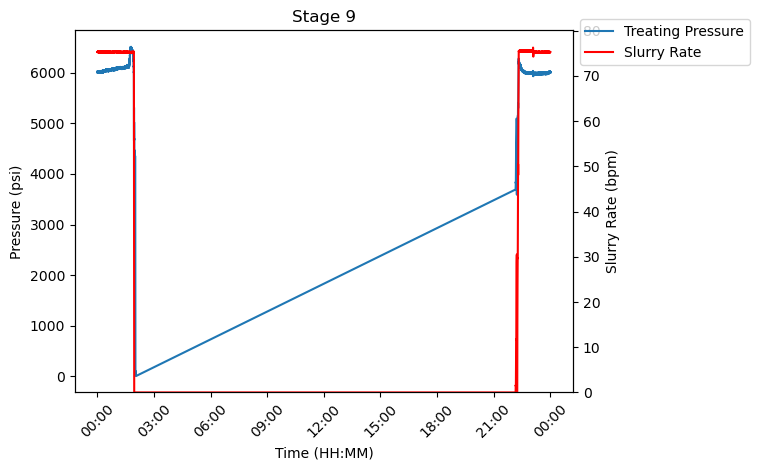

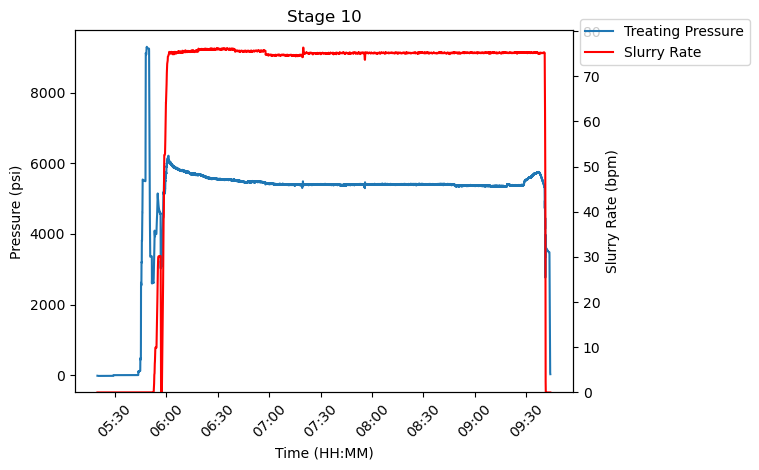

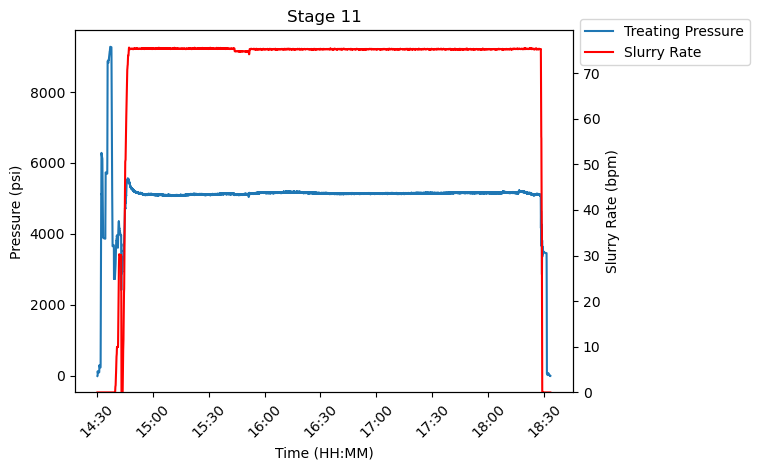

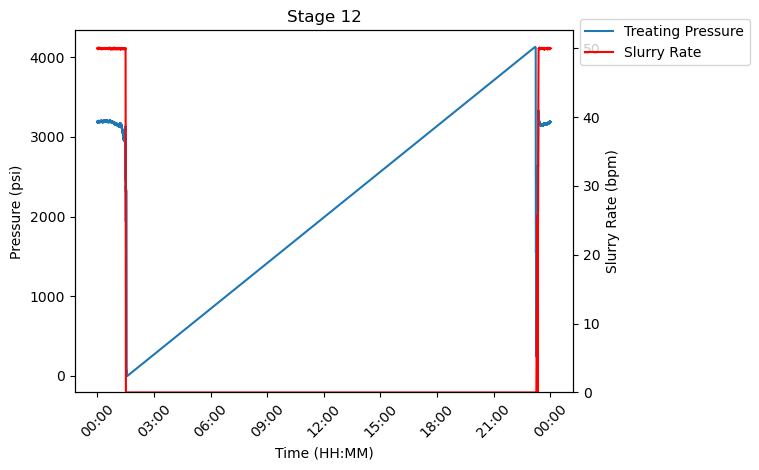

In [3]:
#Plot each stage separately
%matplotlib inline

stage_data = {}
num_stages = frac_data['STAGE_NUMBER'].unique()

for i in range(num_stages.min(),num_stages.max()+1):
    stage_data[i] = frac_data[frac_data['STAGE_NUMBER']==i].copy()
    stage_data[i].sort_index(inplace=True)
    
    full_frac_plot(i)

As we can see from the graphs above, Stages 4, 5, and 12 have errors in the uderlying data. Those stages will be omitted from this analysis for that reason.

## Flag Determination

In order to calculate the frac gradient and open wellhead pressure, we need to create several flags in each frac stage to seperate out the different steps during a frac. We will create 7 different flags: pressure testing (1), open well head (2), initial slurry (3), shut in (4), frac start (5), frac end (6), isip end (7).

For this report we will first create each flag and calculate the frac gradient and open wellhead pressure for Stage 1 and then apply the method to the remaining 8 stages.

### Pressure Testing Flag (Flag 1)

To begin, the pressure testing flag will be applied at the point where the pressure begins to rise over its initial value (we will use 10 psi over the initial value).

2023-05-04 18:04:35


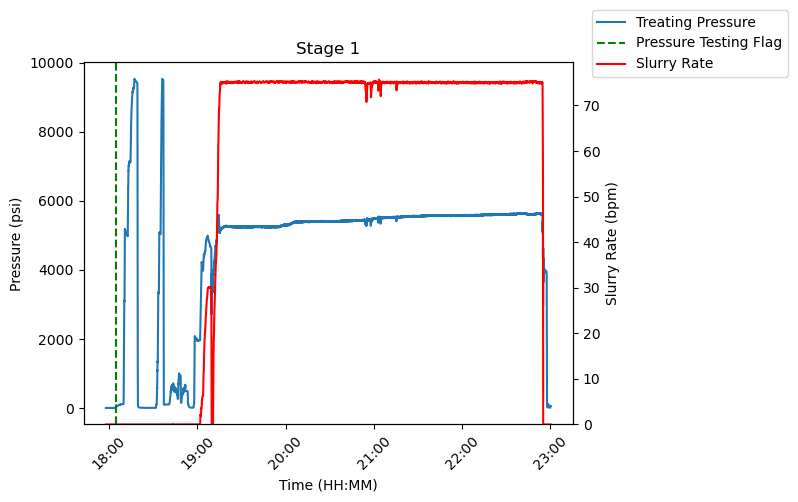

In [4]:
#Determine the initial pressure and flag after 10 psi increase
init_p = stage_data[1]['Treating_Pressure'].iloc[0]
idx1 = (stage_data[1]['Treating_Pressure'] >= init_p + 10).idxmax()
stage_data[1].loc[idx1,'Flag'] = 1

#Plot the stage data and new flag
fig, ax1, ax2 = full_frac_plot(1)
ax1.axvline(idx1,linestyle='dashed',label='Pressure Testing Flag',color='green')
ax2.get_legend().remove()
fig.legend(bbox_to_anchor=(1.25,1.05))
fig.canvas.draw()

print(idx1)

### Initial Slurry Flag (Flag 3)

Next, the initial slurry flag will be applied at the point where the slurry rate first raises above zero (we will use 0.5 bpm to avoid a false flag).

2023-05-04 19:01:53


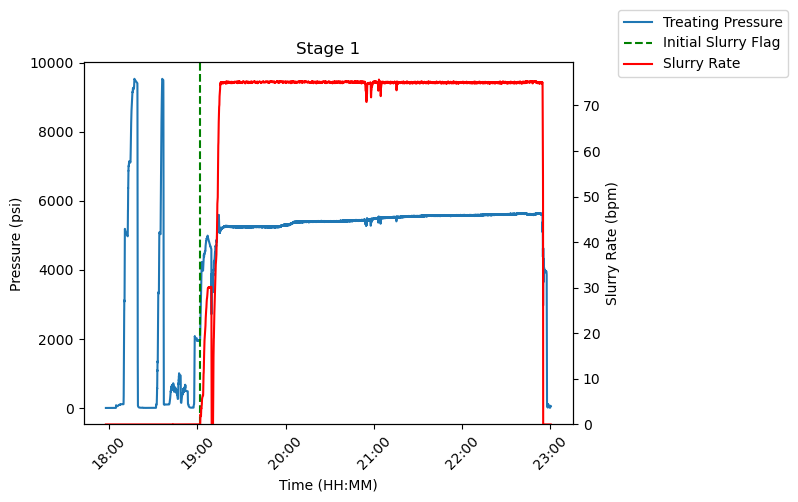

In [5]:
#Flag first occurence of blender slurry rate above 0.5 bpd
idx3 = (stage_data[1]['Blender_Slurry_Rate'] >= 0.5).idxmax()
stage_data[1].loc[idx3,'Flag'] = 3

#Plot the stage data and new flag
fig, ax1, ax2 = full_frac_plot(1)
ax1.axvline(idx3,linestyle='dashed',label='Initial Slurry Flag',color='green')
ax2.get_legend().remove()
fig.legend(bbox_to_anchor=(1.25,1.05))
fig.canvas.draw()

print(idx3)

### Open Well Head Flag (Flag 2)

Now we will set the open well head flag. This flag should occur where the pressure momentarily stabilizes before the initial slurry flag. To do this we will calculate the change in bottom hole pressure between flags 1 and 3 and use that to choose the stable period before flag 3.

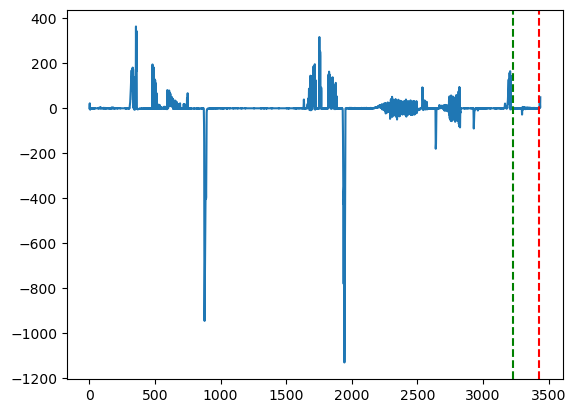

In [6]:
#Slice stage 1 dataset between Flag 1 and Flag 3
s1_f1_to_f3 = stage_data[1].loc[idx1:idx3].copy()

#Create a new dataframe containing the second-to-second treating presure change and plot
tp_change = pd.DataFrame({'tp_change':np.diff(s1_f1_to_f3['Treating_Pressure'])
                             ,'time_stamp':s1_f1_to_f3.index[:-1]})

plt.plot(tp_change['tp_change'])
plt.axvline(3230,linestyle='dashed',color='green')
plt.axvline(3430,linestyle='dashed',color='red')
plt.show()

As we can see here, the open well head pressure should be calculated when the treating pressure is in it's last stable stage between the two vertical lines shown on the graph above. 

Our flag should occur at the green line. To do this we will set the flag where the pressure change is no more than 10 psi from second to second.

We will also trim the data from the end by 15 seconds to make sure we aren't getting any data from the initial slurry injection.

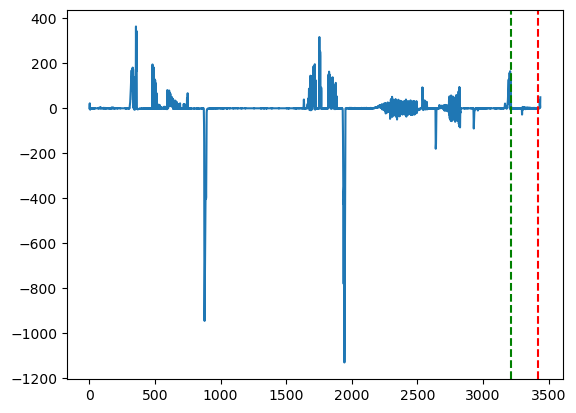

2023-05-04 18:58:08 2023-05-04 19:01:37


In [7]:
#Trim last 15 seconds and flag all occurences of treating pressure change greater than 10 psi
f2 = pd.DataFrame(tp_change[:-15])
f2['tp_flag'] = 0
f2.loc[f2['tp_change']>10,'tp_flag'] = 1

#Reverse f2 so we can find the first occurence of p_change = 1
f2 = f2.reindex(index=f2.index[::-1])

f2id_1 = (f2['tp_flag'] == 1).idxmax()
f2id_2 = f2.iloc[0].name

plt.plot(tp_change['tp_change'])
plt.axvline(f2id_1,linestyle='dashed',color='green')
plt.axvline(f2id_2,linestyle='dashed',color='red')
plt.show()

#Get time stamp of Flag 2 and Flag 3 minus 15 seconds
idx2_a = f2.loc[f2id_1,'time_stamp']
idx2_b = f2.loc[f2id_2,'time_stamp']

print(idx2_a,idx2_b)

Now that we have the time stamp for the open well head flag we can plot it to make sure it looks acceptable and calculate the open well head pressure.

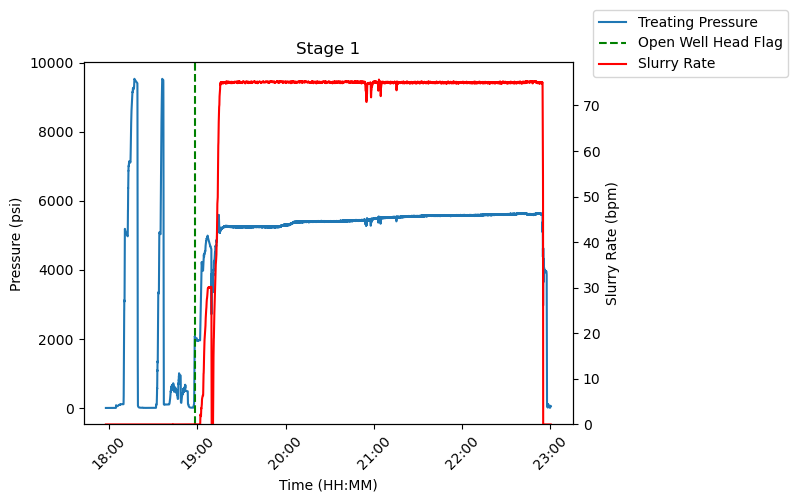

In [8]:
#Plot the stage data and new flag
fig, ax1, ax2 = full_frac_plot(1)
ax1.axvline(idx2_a,linestyle='dashed',label='Open Well Head Flag',color='green')
ax2.get_legend().remove()
fig.legend(bbox_to_anchor=(1.25,1.05))
fig.canvas.draw()

open well head pressure is 1990 psig


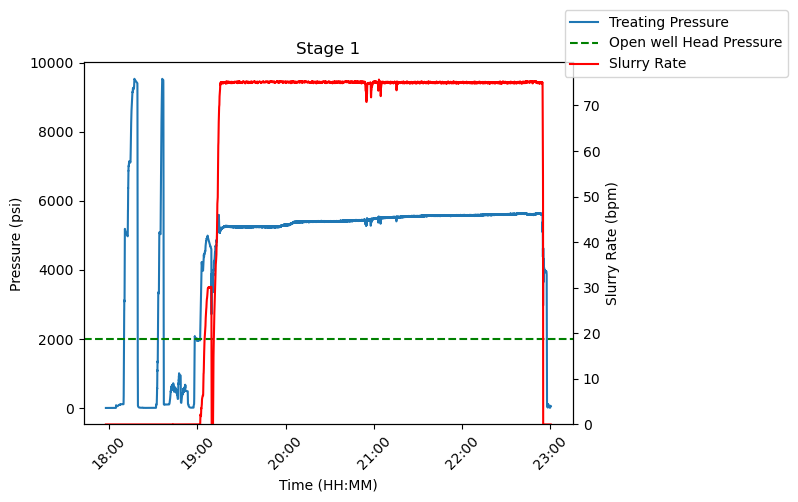

In [9]:
#Plot stage data and calculated open well head pressure
open_well_pressure = stage_data[1]['Treating_Pressure'].loc[idx2_a:idx2_b].mean()
print('open well head pressure is ' + str(round(open_well_pressure)) + ' psig')

fig, ax1, ax2 = full_frac_plot(1)
ax1.axhline(open_well_pressure,linestyle='dashed',label='Open well Head Pressure',color='green')
ax2.get_legend().remove()
fig.legend(bbox_to_anchor=(1.25,1.05))
fig.canvas.draw()

### Shut In Flag (Flag 4)

The shut in flag is determined by the time when the slurry rate reaches 0 bpd after the initial slurry flag. Once again we will use below 0.5 bpd as our limit for this.

2023-05-04 19:09:39


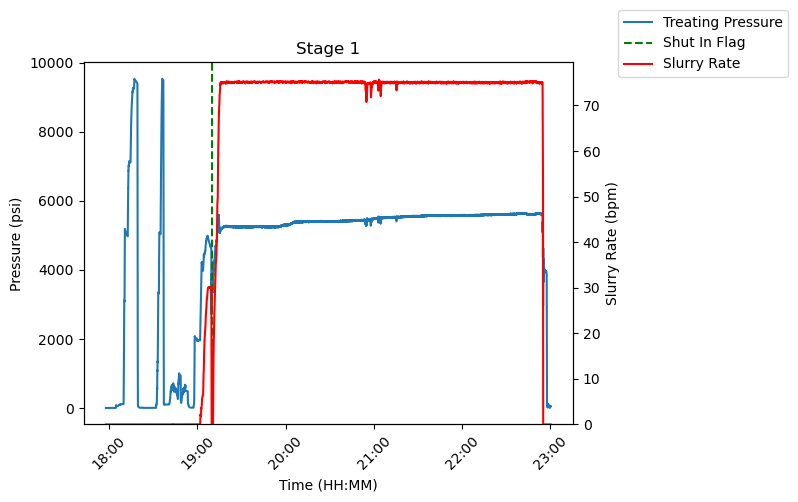

In [10]:
#Flag first occurence of blender slurry rate below 0.5 bpd after Flag 3
idx4 = ((stage_data[1]['Blender_Slurry_Rate'] <= 0.5) & (stage_data[1].index > idx3)).idxmax()
stage_data[1].loc[idx4,'Flag'] = 4

#Plot the stage data and new flag
fig, ax1, ax2 = full_frac_plot(1)
ax1.axvline(idx4,linestyle='dashed',label='Shut In Flag',color='green')
ax2.get_legend().remove()
fig.legend(bbox_to_anchor=(1.25,1.05))
fig.canvas.draw()

print(idx4)

### Frac Start Flag (Flag 5)

The frac start flag occurs when the slurry rate increases above 0 bpd after the shut in flag. We will use 0.5 bpd again for this flag.

2023-05-04 19:10:37


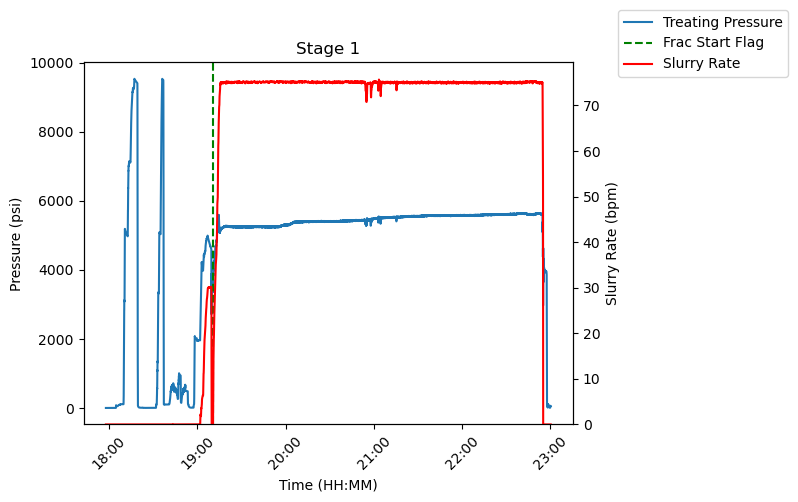

In [11]:
#Flag first occurence of blender slurry rate above 0.5 bpd after Flag 4
idx5 = ((stage_data[1]['Blender_Slurry_Rate'] >= 0.5) & (stage_data[1].index > idx4)).idxmax()
stage_data[1].loc[idx5,'Flag'] = 5

#Plot the stage data and new flag
fig, ax1, ax2 = full_frac_plot(1)
ax1.axvline(idx5,linestyle='dashed',label='Frac Start Flag',color='green')
ax2.get_legend().remove()
fig.legend(bbox_to_anchor=(1.25,1.05))
fig.canvas.draw()

print(idx5)

### Frac End Flag (Flag 6)

The frac end flag is set when the slurry rate drops below 0 bpd for the last time in the stage. 0.5 bpd will be used for the limit again.

2023-05-04 22:54:59


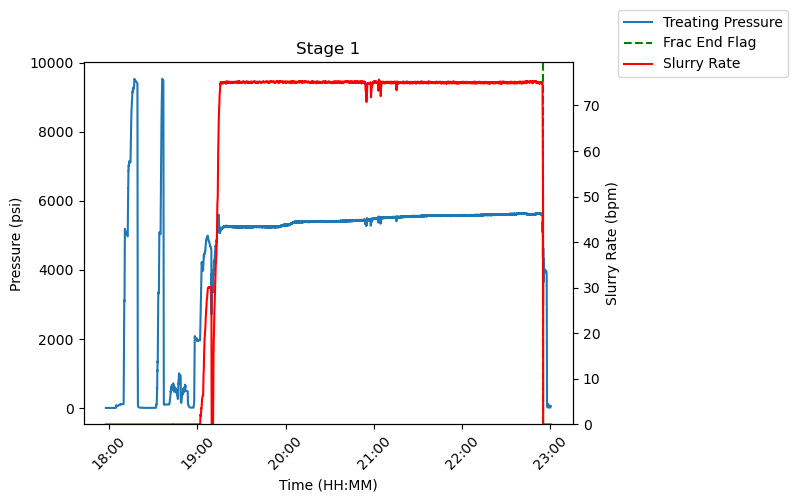

In [12]:
#Reverse the index of the stage data to find the last occurence of slurry rate above 0.5 bpd

f6 = stage_data[1].reindex(index=stage_data[1].index[::-1])
idx6 = (f6['Blender_Slurry_Rate'] >= 0.5).idxmax()
stage_data[1].loc[idx6,'Flag'] = 6

#Plot the stage data and new flag
fig, ax1, ax2 = full_frac_plot(1)
ax1.axvline(idx6,linestyle='dashed',label='Frac End Flag',color='green')
ax2.get_legend().remove()
fig.legend(bbox_to_anchor=(1.25,1.05))
fig.canvas.draw()

print(idx6)

### ISIP End Flag (Flag 7)

The isip end flag should occur when the treatment pressure begins to drop back towards zero. The flag should occur just before the pressure begins to drop so a propoer frac gradient calculation can be made. To do this we will find the last large negative pressure drop and flag just before that happens.

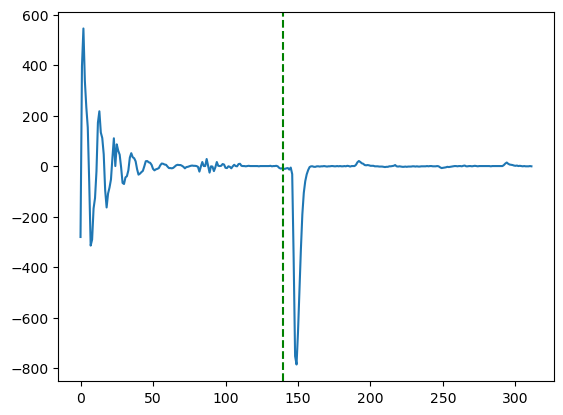

In [13]:
#Slice stage 1 dataset between Flag 6 and the end
s1_f6_to_end = stage_data[1].loc[idx6:].copy()

#Create a new dataframe containing the second-to-second treating presure change and plot
tp_change = pd.DataFrame({'tp_change':np.diff(s1_f6_to_end['Treating_Pressure'])
                             ,'time_stamp':s1_f6_to_end.index[:-1]})

plt.plot(tp_change['tp_change'])
plt.axvline(140,linestyle='dashed',color='green')
plt.show()

The green line is about where we want the flag to be. In order to set this we will find the minimum pressure change and go 15 seconds before that point. I am iffy on this and want to test it on other stages but for now will try this method.

2023-05-04 22:57:13


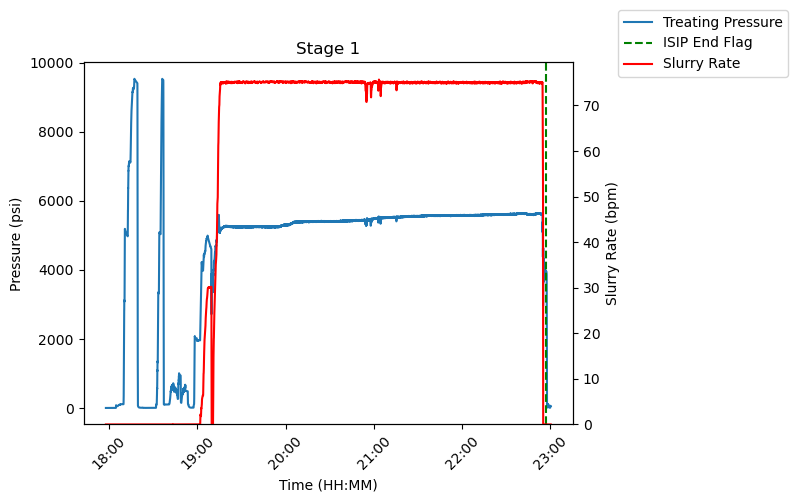

In [14]:
#Find the minimum pressure change value. Subtract 15 seconds from this and assign as Flag 7
f7id = np.argmin(tp_change['tp_change'])
idx7 = tp_change.loc[f7id-15,'time_stamp']

#Plot the stage data and new flag
fig, ax1, ax2 = full_frac_plot(1)
ax1.axvline(idx7,linestyle='dashed',label='ISIP End Flag',color='green')
ax2.get_legend().remove()
fig.legend(bbox_to_anchor=(1.25,1.05))
fig.canvas.draw()

print(idx7)

## ISIP Calcs

Now that we have all flags set we can calculated the initial and final ISIP. To do this we will focus on the frac data between Flags 4-5 and Flags 6-7. Then we will perform a linear regression on the treatment pressure and select the point where the linear regression intersects the first flag as the ISIP.

### Initial ISIP

The initial ISIP will be calculated using the frac data between the Shut In Flag (Flag 4) and the Frac Start Flag (Flag 5).

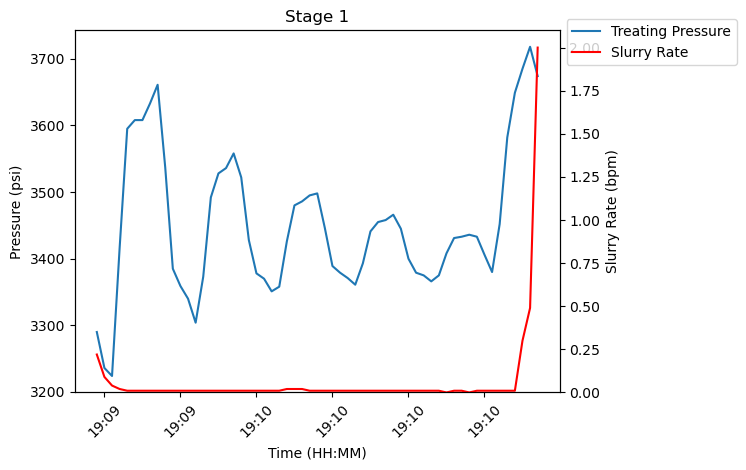

In [15]:
#Slice stage 1 dataset between Flag 4 and Flag 5
s1_f4_to_f5 = stage_data[1].loc[idx4:idx5].copy()

#Plot the data between Flag 4-5
fig, ax1, ax2 = flag_frac_plot(1,idx4,idx5)

As we can see we have a few points at the start and end that will affect the linear regression. To clean this up we will restrict this data to the first and last occurences of no change in the slurry rate minus an extra second.

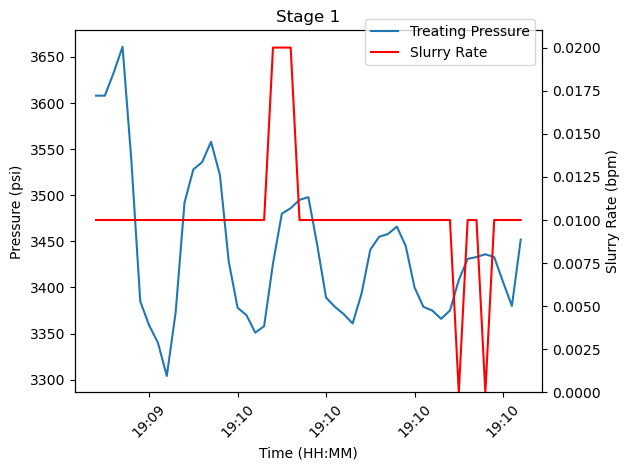

In [16]:
#Calculate the change in slurry rate and restrict data set to first and last occurence of no change
sl_change = pd.DataFrame({'sl_change':np.diff(s1_f4_to_f5['Blender_Slurry_Rate'])
                             ,'time_stamp':s1_f4_to_f5.index[:-1]})

sl_change_rev = sl_change.reindex(index=sl_change.index[::-1])

idx4_a = sl_change.loc[(sl_change['sl_change'] == 0).idxmax() + 1,'time_stamp']
idx5_a = sl_change.loc[(sl_change_rev['sl_change'] == 0).idxmax() - 1,'time_stamp']

#Plot the trimmed data
fig, ax1, ax2 = flag_frac_plot(1,idx4_a,idx5_a)

Now we are ready for the linear regression to find the initial ISIP.

The initial ISIP is 3496 psig


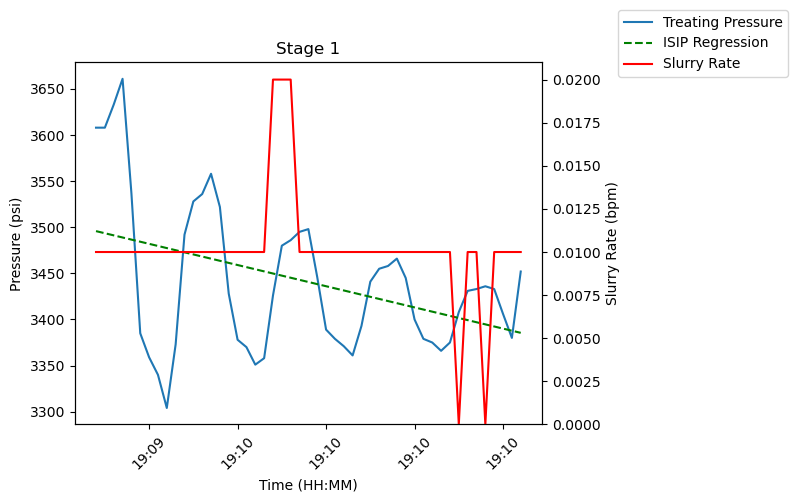

In [17]:
from sklearn.linear_model import LinearRegression
import datetime as dt

#Set up and perform a regression on the trimmed dataset
X_date = pd.Series(stage_data[1][idx4_a:idx5_a].index)
X = X_date.apply(lambda x: x.timestamp()).values.reshape(-1,1)

y = stage_data[1][idx4_a:idx5_a]['Treating_Pressure']

reg = LinearRegression().fit(X,y)

y_pred = reg.predict(X)
isip_init = y_pred[0]
print('The initial ISIP is ' + str(round(isip_init)) + ' psig')

#Plot the trimmed data and add the regression
fig, ax1, ax2 = flag_frac_plot(1,idx4_a,idx5_a)
ax1.plot(X_date,y_pred,linestyle='dashed',label='ISIP Regression',color='green')
ax2.get_legend().remove()
fig.legend(bbox_to_anchor=(1.25,1.05))
fig.canvas.draw()

### Finial ISIP

For the final ISIP we will use the same method from above and apply it to the data between the Frac End Flag (Flag 6) and the ISIP End Flag (Flag 7).

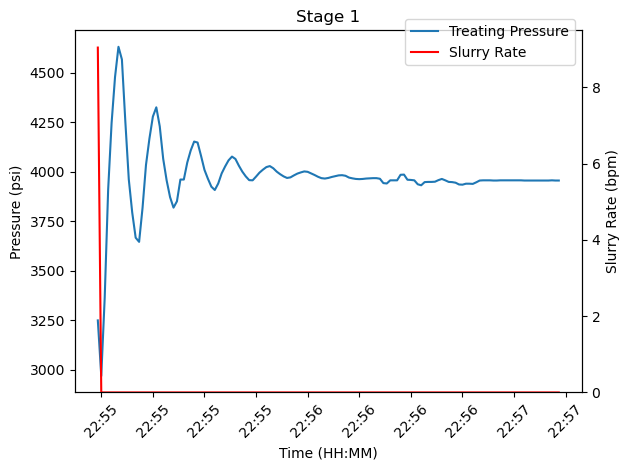

In [18]:
#Slice stage 1 dataset between Flag 6 and Flag 7
s1_f6_to_f7 = stage_data[1].loc[idx6:idx7].copy()

#Plot the data between Flag 6-7
fig, ax1, ax2 = flag_frac_plot(1,idx6,idx7)

Once again we can see we have a few points at the start that will affect the linear regression. To clean this up we will restrict this data to the first and last occurences of no change in the slurry rate minus an extra second.

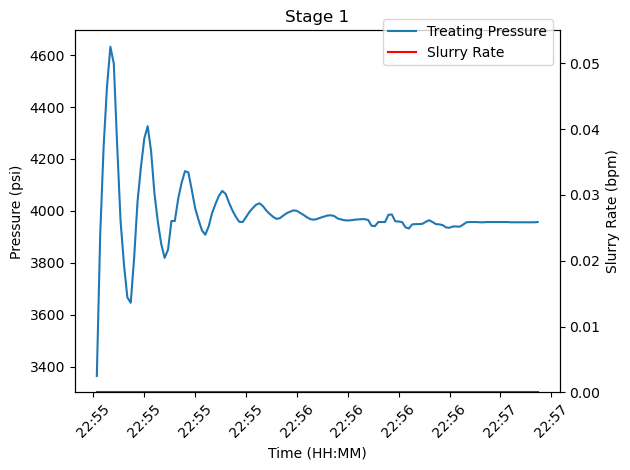

In [19]:
#Calculate the change in slurry rate and restrict data set to first and last occurence of no change
sl_change = pd.DataFrame({'sl_change':np.diff(s1_f6_to_f7['Blender_Slurry_Rate'])
                             ,'time_stamp':s1_f6_to_f7.index[:-1]})

sl_change_rev = sl_change.reindex(index=sl_change.index[::-1])

idx6_a = sl_change.loc[(sl_change['sl_change'] == 0).idxmax() + 1,'time_stamp']
idx7_a = sl_change.loc[(sl_change_rev['sl_change'] == 0).idxmax() - 1,'time_stamp']

#Plot the trimmed data
fig, ax1, ax2 = flag_frac_plot(1,idx6_a,idx7_a)

Now we are ready for the linear regression to find the final ISIP.

The final ISIP is 4045 psig


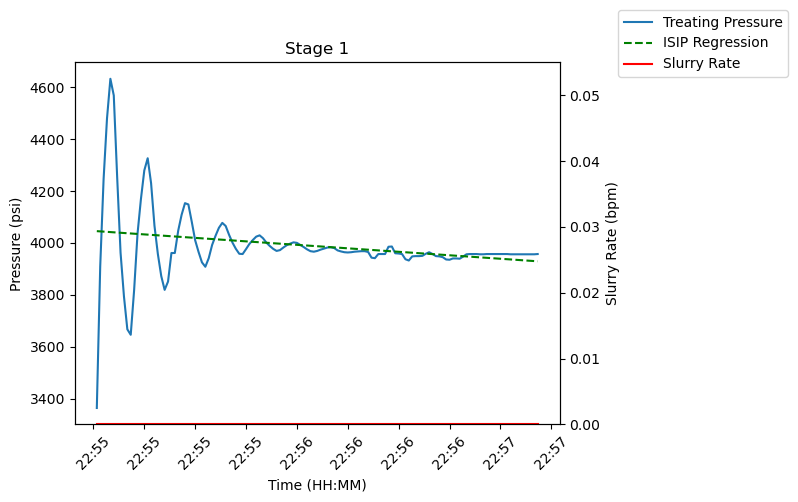

In [20]:
#Set up and perform a regression on the trimmed dataset
X_date = pd.Series(stage_data[1][idx6_a:idx7_a].index)
X = X_date.apply(lambda x: x.timestamp()).values.reshape(-1,1)

y = stage_data[1][idx6_a:idx7_a]['Treating_Pressure']

reg = LinearRegression().fit(X,y)

y_pred = reg.predict(X)
isip_init = y_pred[0]
print('The final ISIP is ' + str(round(isip_init)) + ' psig')

#Plot the trimmed data and add the regression
fig, ax1, ax2 = flag_frac_plot(1,idx6_a,idx7_a)
ax1.plot(X_date,y_pred,linestyle='dashed',label='ISIP Regression',color='green')
ax2.get_legend().remove()
fig.legend(bbox_to_anchor=(1.25,1.05))
fig.canvas.draw()